In [60]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
from numpy import sin, cos, pi
import matplotlib.pyplot as plt

In [61]:
## Parameters
# limb lengths
l_1, l_2 = 0.5, 0.5
# limb masses
m_1, m_2 = 7, 7
# body mass
m_A = 75
# gravity
g = 9.81
# joint stiffnesses
k_B = 1
# joint damping
b_B = 1
# joint neutral angles
psi_B = pi/12
# Walking speed
v = 0.5

In [62]:
# Made-up data
#n = 30 # keep below 30 for stability
#t_array = np.linspace(0, 10, n)
#y_array = 0.1 * cos(pi * t_array)
#theta_1_array = sin(pi * t_array)

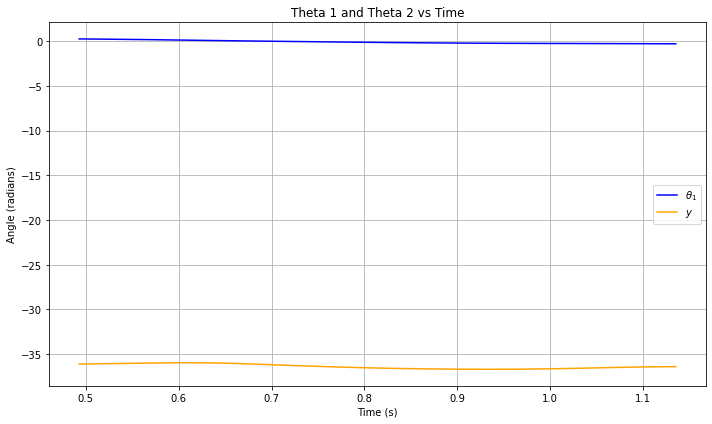

In [63]:
# Real data
import pandas as pd

# Load the data
data = pd.read_csv("Walking Data (theta1, theta2, y).csv")

# Convert time from milliseconds to seconds for plotting
t_array = data["Time (ms)"].to_numpy() / 1000.0
t_array = t_array[15:35]
theta_1_array = data["Theta 1"].to_numpy() * np.pi / 180
theta_1_array = theta_1_array[15:35]
y_array = data["y"].to_numpy()
y_array = y_array[15:35]

theta_2_array = data["Theta 2"].to_numpy()* np.pi / 180
theta_2_array = theta_2_array[15:35]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t_array, theta_1_array, color="blue", label=r"$ \theta_1 $")
plt.plot(t_array, y_array, color="orange", label=r'$y$')

plt.title("Theta 1 and Theta 2 vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Angle (radians)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [64]:
# Create interpolators for data
y_interp = CubicSpline(t_array, y_array)
a_interp = y_interp.derivative(2)

theta_1_interp = CubicSpline(t_array, theta_1_array)
omega_1_interp = theta_1_interp.derivative(1)
alpha_1_interp = theta_1_interp.derivative(2)

In [65]:
# functions for inputs of time from interpolators
def y_func(t):
    return y_interp(t)

def a_func(t):
    return a_interp(t)

def theta_1_func(t):
    return theta_1_interp(t)

def omega_1_func(t):
    return omega_1_interp(t)

def alpha_1_func(t):
    return alpha_1_interp(t)

In [66]:
def swing(t, state):
    # determine input values
    a = a_func(t)
    theta_1 = theta_1_func(t)
    omega_1 = omega_1_func(t)
    alpha_1 = alpha_1_func(t)

    # unpack state
    theta_2 = state[0]
    omega_2 = state[1]

    # calculate derivatives with EOMs
    alpha_2 = 3*b_B*omega_1/(l_2**2*m_2) - 3*b_B*omega_2/(l_2**2*m_2) - 3*g*sin(theta_2)/(2*l_2) - 3*k_B*psi_B/(l_2**2*m_2) + 3*k_B*theta_1/(l_2**2*m_2) - 3*k_B*theta_2/(l_2**2*m_2) + 3*l_1*sin(theta_1 - theta_2)*omega_1**2/(2*l_2) - 3*l_1*cos(theta_1 - theta_2)*alpha_1/(2*l_2) - 3*sin(theta_2)*a/(2*l_2)

    # Pack derivatives into array and return
    return np.array((omega_2, alpha_2))


In [67]:
# Initial conditions
theta_2_0 = theta_2_array[0]
omega_2_0 = (theta_2_array[1] - theta_2_array[0]) / (t_array[1] - t_array[0])
state0 = np.array([theta_2_0, omega_2_0])

In [68]:
# Solve IVP
t_span = (t_array[0], t_array[-1])

t_eval = np.linspace(*t_span, 1000)
solution = solve_ivp(swing, t_span, state0, t_eval= None)

In [69]:
# Unpack Solution
t = solution.t
state = solution.y
theta_2 = state[0, :]
omega_2 = state[0, :]

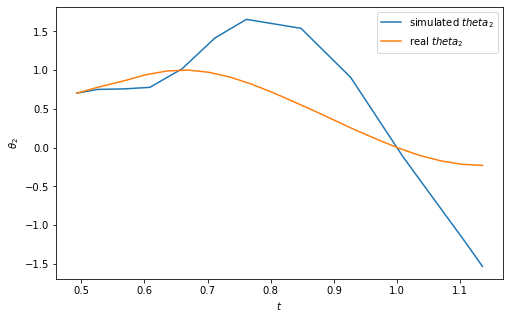

In [70]:
# Plot Solution
plt.figure(figsize=(8,5))
plt.plot(t, theta_2, label="simulated $theta_2$")
plt.plot(t_array, theta_2_array, label= "real $theta_2$")
plt.xlabel(r'$t$')
plt.ylabel(r'$\theta_2$')
plt.legend()
plt.show()

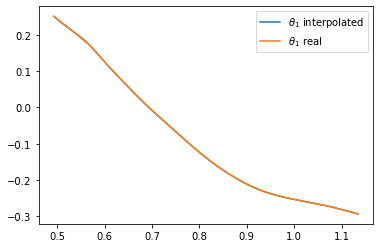

In [71]:
#plt.plot(t_eval, y_func(t_eval), label=r"$y$")
plt.plot(t_eval, theta_1_func(t_eval), label=r"$\theta_1$ interpolated")
plt.plot(t_array, theta_1_array, label=r"$\theta_1$ real")
#plt.plot(t_array, theta_2_array, label=r"$\theta_2$")
plt.legend()
plt.show()

In [72]:
# Havent worked on the optimizer yet

# Optimizer_updated

In [94]:
from scipy.optimize import least_squares

def simulate_theta2(params, t_meas, theta2_meas, state0, l_1, l_2):
    # Unpack parameters (excluding l_1 and l_2)
    k_B, b_B, psi_B, m_1, m_2 = params

    def swing(t, state):
        theta_2, omega_2 = state
        a = a_func(t)
        theta_1 = theta_1_func(t)
        omega_1 = omega_1_func(t)
        alpha_1 = alpha_1_func(t)

        alpha_2 = (3*b_B*omega_1/(l_2**2*m_2)
                   - 3*b_B*omega_2/(l_2**2*m_2)
                   - 3*g*sin(theta_2)/(2*l_2)
                   - 3*k_B*psi_B/(l_2**2*m_2)
                   + 3*k_B*theta_1/(l_2**2*m_2)
                   - 3*k_B*theta_2/(l_2**2*m_2)
                   + 3*l_1*sin(theta_1 - theta_2)*omega_1**2/(2*l_2)
                   - 3*l_1*cos(theta_1 - theta_2)*alpha_1/(2*l_2)
                   - 3*sin(theta_2)*a/(2*l_2))
        
        return [omega_2, alpha_2]

    sol = solve_ivp(swing, (t_meas[0], t_meas[-1]), state0, t_eval=t_meas)

    if not sol.success:
        return np.full_like(theta2_meas, np.inf)  # penalize bad sim

    theta2_sim = sol.y[0]
    return theta2_sim - theta2_meas

def residuals(params):
    return simulate_theta2(params, t_array, theta_2_array, state0, l_1_fixed, l_2_fixed)


In [95]:
# Initial guesses for [k_B, b_B, psi_B, l_1, l_2, m_1, m_2]

H = 1.75

l_1_fixed = 0.30 * H
l_2_fixed = 0.30 * H

p0 = [
      10,        # k_B
      10,        # b_B
      np.pi/12,  # psi_B
      #0.5, 0.5, # l_1, l_2
      7.0, 7.0    # m1, m2
     ]

# Reasonable physical bounds for stability and realism
lower_bounds = [
                0.01, # k_B
                0.01, # b_B
                0.0,  # psi_B
                #0.3, 0.3 # L_1, l_2
                2.0,  # m1
                2.0   # m2
                ]

upper_bounds = [
                20.0,    # k_B
                20.0,    # b_B
                np.pi/2, # psi_B
                #1.0, 1.0 # l_1, l_2
                20.0,    # m1
                20.0     # m2
               ]


In [97]:
result = least_squares(residuals,
                       x0=p0,
                       bounds=(lower_bounds, upper_bounds),
                       verbose=2)

print("Optimized parameters:", result.x)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.8921e-01                                    1.16e+01    
       1              3         3.7928e-01      9.92e-03       3.33e-02       1.46e+00    
       2              7         3.7927e-01      7.48e-06       1.29e-04       2.03e+00    
       3              8         3.7926e-01      1.78e-05       1.52e-04       5.34e+00    
       4              9         3.7918e-01      7.90e-05       1.62e-04       4.70e+00    
       5             10         3.7855e-01      6.24e-04       3.23e-04       8.92e+00    
       6             11         3.7808e-01      4.68e-04       6.53e-04       7.24e+00    
       7             12         3.7730e-01      7.90e-04       1.30e-03       5.43e+00    
       8             13         3.7670e-01      5.92e-04       2.58e-03       5.45e+00    
       9             14         3.7653e-01      1.72e-04       2.62e-03       1.41e+00    

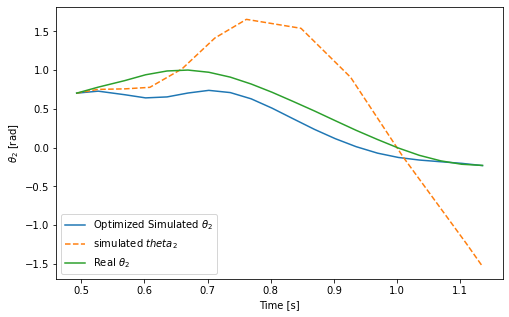

In [99]:
theta2_fit = simulate_theta2(result.x, t_array, theta_2_array, state0, l_1_fixed, l_2_fixed) + theta_2_array

plt.figure(figsize=(8, 5))
plt.plot(t_array, theta2_fit, label="Optimized Simulated $\\theta_2$")
plt.plot(t, theta_2, "--", label="simulated $theta_2$")
plt.plot(t_array, theta_2_array, label="Real $\\theta_2$")
plt.xlabel("Time [s]")
plt.ylabel("$\\theta_2$ [rad]")
plt.legend()
plt.show()


# Optimization

In [15]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import BarycentricInterpolator
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# ─── 1) Synthetic reference data ────────────────────────────
t_ref = np.linspace(0, 10, 200)
A_ref, f_ref, damping, noise = 0.5, 1.5, 0.5, 0.02
theta2_ref = A_ref * np.exp(-damping * t_ref) * np.sin(2*np.pi*f_ref*t_ref)
theta2_ref += noise * np.random.randn(len(t_ref))

# ─── 2) Build your input interpolators ───────────────────────────────────────
n_input = 20
t_in = np.linspace(0, 10, n_input) # Input t
y_in = 0.1 * np.cos(np.pi * t_in) # input y
theta1_in = np.sin(np.pi * t_in) # input theta1

y_ip      = BarycentricInterpolator(t_in, y_in) 
theta1_ip = BarycentricInterpolator(t_in, theta1_in)

def a_func(t):     return y_ip.derivative(t, 2)
def theta1_func(t):return theta1_ip(t)
def omega1_func(t):return theta1_ip.derivative(t, 1)
def alpha1_func(t):return theta1_ip.derivative(t, 2)

# ─── 3) Simulation wrapper now only takes 5 params ───────────────────────────
def simulate_theta2(free_params, t_eval):
    """
    free_params = [m1, m2, kB, bB, psiB]
    uses fixed l1, l2 from outer scope
    """
    m1, m2, kB, bB, psiB = free_params
    g = 9.81

    def swing_param(t, state):
        theta2, omega2 = state
        # inputs
        a   = a_func(t)
        th1 = theta1_func(t)
        om1 = omega1_func(t)
        alp1= alpha1_func(t)
        # EOM for swing‐leg angular acceleration
        alpha2 = (
            3*bB*om1/(l2**2*m2)
          - 3*bB*omega2/(l2**2*m2)
          - 3*g*np.sin(theta2)/(2*l2)
          - 3*kB*psiB/(l2**2*m2)
          + 3*kB*th1/(l2**2*m2)
          - 3*kB*theta2/(l2**2*m2)
          + 3*l1*np.sin(th1 - theta2)*om1**2/(2*l2)
          - 3*l1*np.cos(th1 - theta2)*alp1/(2*l2)
          - 3*np.sin(theta2)*a/(2*l2)
        )
        return [omega2, alpha2]

    # initial cond: start at ref angle, zero vel
    y0 = [theta2_ref[0], 0.0]
    sol = solve_ivp(swing_param,
                    (t_eval[0], t_eval[-1]),
                    y0,
                    t_eval=t_eval,
                    max_step=0.01)
    return sol.t, sol.y[0]

# ─── 4) Residuals function ───────────────────────────────────────────────────
def residuals(free_params):
    t_sim, th2_sim = simulate_theta2(free_params, t_ref)
    th2_on_ref = np.interp(t_ref, t_sim, th2_sim)
    return th2_on_ref - theta2_ref


In [16]:
H = 1.75
l1 = 0.25 * H    # femur
l2 = 0.25 * H    # tibia

# Initial Values
p0    = [5.0, 5.0,    # m1, m2
         1.0, 1.0,    # kB, bB
         np.pi/12]    # psiB

lower = [3, 3, 0.0, 0.0, 0.0]
upper = [20, 20, 10.0, 10.0, np.pi/6]

print("Starting optimization...")
result = least_squares(residuals, p0, bounds=(lower, upper),
                       xtol=1e-6, ftol=1e-6, verbose=2)

# ─── 6) Report fitted values ────────────────────────────────────────────────
names = ["m1","m2","kB","bB","psiB"]
print("\nFitted parameters:")
for name, val in zip(names, result.x):
    print(f"  {name} = {val:.4f}")


Starting optimization...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.2019e+03                                    1.07e+04    
       1              2         8.9041e+02      2.31e+03       2.44e+00       3.15e+02    


KeyboardInterrupt: 

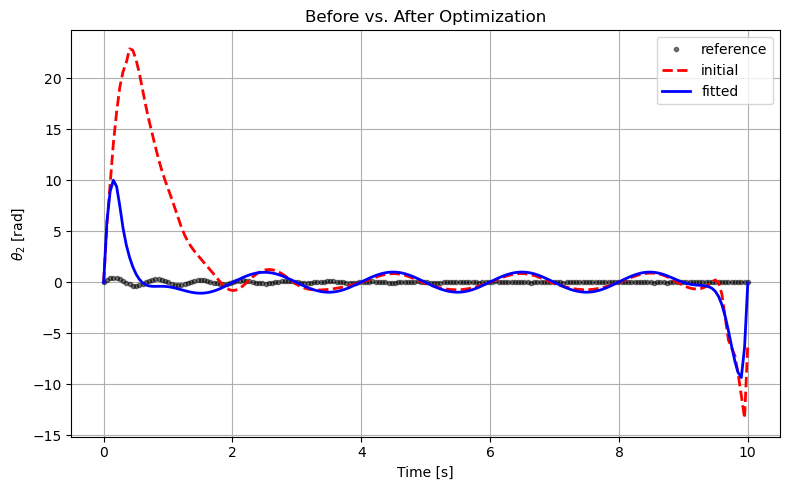

In [ ]:
# ─── 7) (Optional) Plot before vs. after ────────────────────────────────────
_, th2_before = simulate_theta2(p0, t_ref)
_, th2_after  = simulate_theta2(result.x, t_ref)

plt.figure(figsize=(8,5))
plt.plot(t_ref, theta2_ref, 'k.', alpha=0.5, label='reference')
plt.plot(t_ref, th2_before,'r--', lw=2, label='initial')
plt.plot(t_ref, th2_after, 'b-',  lw=2, label='fitted')
plt.xlabel('Time [s]')
plt.ylabel(r'$\theta_2$ [rad]')
plt.legend()
plt.title('Before vs. After Optimization')
plt.grid(True)
plt.tight_layout()
plt.show()